# Analyse hydrogen market results from Pypsa-Earth network
This notebook analyze the hydrogen market data of the network (.nc) file. It generates comprehensive plots and summaries to visualize the results.
* Hydrogen Market Value
* Hydrogen Production Cost
* Hydrogen Capacity 
* Hydrogen Export 

Sources: 
- locAL DEcarbonization and HYDrogen Export: https://github.com/energyLS/aldehyde 
- Statistics module: https://pypsa.readthedocs.io/en/latest/examples/statistics.html
- Templates and colors: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/network_analysis.ipynb

File is needed:
* PyPSA network file (.nc) includes the hydrogen financing information.

## Import packages

In [3]:
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt
import pandas as pd

## Path settings
This section reads the config parameters from your config.yaml file and automatically reads the output of the optimization with those settings

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# Set your pypsa-earth directory here
PARENT = "/home/pypsa-earth/"
# Set your network path (.nc) here
network_path = PARENT + f"results/networks/elec_s_10_ec_lc3.0_Co2L_3H_2035_0.071_AB_14export.nc"
n = pypsa.Network(network_path)
statistics = n.statistics()
config_path = PARENT + f"/config.yaml"
config = yaml.safe_load(open(config_path))

### Hydrogen Market

In [64]:
# Market
h2_market = (statistics.loc["Link", "H2 Electrolysis"]["Market Value"]).round(2)
print(f"Hydrogen Market is: {h2_market} €")

Hydrogen Market is: 12.82 €


### Hydrogen Costs

In [31]:
h2_capex = (
        statistics.loc["Link", "H2 Electrolysis"]
        .loc["Capital Expenditure"]
        .round(2)
        / 1e6
)  # in Mio. €
print(f"Capital Expenditure is: {h2_capex} Mio. €")

h2_opex = (
    statistics.loc["Link", "H2 Electrolysis"]
    .loc["Operational Expenditure"]
    .round(2)
    / 1e6
)  # in Mio. €
print(f"Operational Expenditure is: {h2_opex} Mio. €")

hydrogen_production = (
    statistics.loc["Link", "H2 Electrolysis"]
    .loc["Supply"]
    .sum() 
    / 1e6
)  # in TWh

total_hydrogen_production_cost = h2_capex + h2_opex

hydrogen_cost_per_unit = total_hydrogen_production_cost / hydrogen_production

# Print Results
print(f"Total Hydrogen Production Cost: {total_hydrogen_production_cost} Mio. €")
print(f"Hydrogen Production Cost per Unit: {hydrogen_cost_per_unit} Mio. € per TWh")


Capital Expenditure is: 210.44656 Mio. €
Operational Expenditure is: 0.21842496 Mio. €
Total Hydrogen Production Cost: 210.66498496 Mio. €
Hydrogen Production Cost per Unit: 12.819730658113464 Mio. € per TWh


### Hydrogen Exports

In [65]:
H2_export_MWh = (
            n.stores[
                (n.stores.carrier == "H2") & (n.stores.bus == "H2 export bus")
            ].e_nom_opt.sum()
        )  # in GWh
print(f"Hydrogen Export is: {H2_export_MWh} MWh")

Hydrogen Export is: 333662848.5062631 MWh


In [67]:
H2_export_revenue = H2_export_MWh*h2_market
print(f"Hydrogen Export Revenue is: {H2_export_revenue/ 1e6} Mio. €")

Hydrogen Export Revenue is: 4277.557717850293 Mio. €


### Hydrogen Capacity

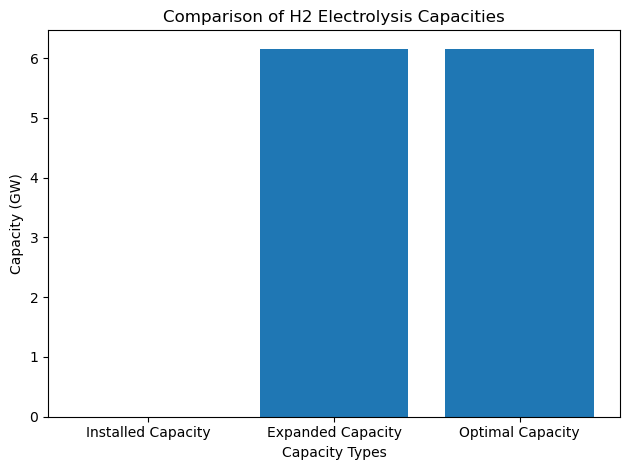

In [49]:
installed_capacity = n.statistics.installed_capacity(comps='Link').loc["H2 Electrolysis"]/ 1e3
expanded_capacity = n.statistics.expanded_capacity(comps='Link').loc["H2 Electrolysis"]/ 1e3
optimal_capacity = n.statistics.optimal_capacity(comps='Link').loc["H2 Electrolysis"]/ 1e3

categories = ['Installed Capacity', 'Expanded Capacity', 'Optimal Capacity']
values = [installed_capacity, expanded_capacity, optimal_capacity]

plt.figure()
plt.bar(categories, values)
plt.title('Comparison of H2 Electrolysis Capacities')
plt.ylabel('Capacity (GW)') 
plt.xlabel('Capacity Types')
plt.tight_layout()
plt.show()
